# Bolt - Supply Data Analysis

## Table of Contents

- [Problem Statement](#Problem-Statement)
- [Importing Libraries](#Importing-Libraries)
- [Loading Data](#Loading-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Analysis](#Data-Analysis)
    + [Defining actual demand and supply](#Defining-actual-demand-and-supply)
    + [Which 36 hours in a week are most undersupplied](#Which-36-hours-in-a-week-are-most-undersupplied)
    + [24-hour curve of average supply and demand](#24-hour-curve-of-average-supply-and-demand)
    + [Visualisation of hours where we lack supply during a weekly period](#Visualisation-of-hours-where-we-lack-supply-during-a-weekly-period)
    + [Number of hours needed to ensure we can meet all the demand](#Number-of-hours-needed-to-ensure-we-can-meet-all-the-demand)
    + [Number of hours needed to ensure we have a high Coverage Ratio on peak hours daily](#Number-of-hours-needed-to-ensure-we-have-a-high-Coverage-Ratio-on-peak-hours-daily)
    + [Levels of guaranteed hourly earnings we can offer to drivers during 36 weekly hours with highest demand](#Levels-of-guaranteed-hourly-earnings-we-can-offer-to-drivers-during-36-weekly-hours-with-highest-demand)
- [Summary](#Summary)

## Problem Statement

Important part of our business is a supply/demand balance. We can’t control demand but we can shift some supply to necessary hours to cover more demand during peaks.  
Perform a supply and demand analysis. Identify supply to demand dynamics. Estimate number of hours needed to ensure we have a high Coverage Ratio during most peak hours.
Evaluate an acceptable level of guaranteed hourly earnings during peak hours to motivate drivers to join Bolt.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = None

## Loading Data

### Loading Supply data

Let's load and have a look at Hourly Driver Activity data.

In [2]:
da = pd.read_csv('Hourly_DriverActivity_1.csv')

da.head()

,Date,Active drivers,Online (h),Has booking (h),Waiting for booking (h),Busy (h),Hours per active driver,Rides per online hour,Finished Rides
0,2016-12-18 23,52,18,6,11,11,0.30,0.67,12.00
1,2016-12-18 22,59,20,11,9,12,0.30,1.40,28.00
2,2016-12-18 21,72,25,7,18,15,0.30,0.64,16.00
3,2016-12-18 20,86,29,7,23,15,0.30,0.52,15.00
4,2016-12-18 19,82,31,14,17,19,0.40,1.16,36.00


In [3]:
# basic info about rows and columns
def df_cols(df):
    print('We have the following list of columns:')
    for i in df.columns:
        print('-', i)
    print(f'\nSummary: the data has {df.shape[0]} rows and {df.shape[1]} columns.')

In [4]:
df_cols(da)

We have the following list of columns:
- Date
- Active drivers
- Online (h)
- Has booking (h)
- Waiting for booking (h)
- Busy (h)
- Hours per active driver
- Rides per online hour
- Finished Rides

Summary: the data has 840 rows and 9 columns.


In [5]:
# Renaming columns for our convenience
da = da.rename(columns={'Date': 'date',
                 'Active drivers':'active_drivers',
                 'Online (h)': 'online_h',
                 'Has booking (h)': 'has_booking_h',
                 'Waiting for booking (h)': 'waiting_booking_h',
                 'Busy (h)': 'busy_h',
                 'Hours per active driver': 'hpad',
                 'Rides per online hour': 'rph',
                 'Finished Rides': 'finished_rides'})

In [6]:
# the general info about data and data types. Also checking for missing values
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               840 non-null    object 
 1   active_drivers     840 non-null    int64  
 2   online_h           840 non-null    int64  
 3   has_booking_h      840 non-null    int64  
 4   waiting_booking_h  840 non-null    int64  
 5   busy_h             840 non-null    int64  
 6   hpad               840 non-null    float64
 7   rph                840 non-null    float64
 8   finished_rides     795 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 59.2+ KB


We have some values missing in the column finish_rides. We'll substitute this missing values with zeros, because if we have a look at data we can notice that when finished_rides value is missing the field riders_per_online has a zero value, it means that finished_rides were zeroes in this row.

In [7]:
da['finished_rides'] = da.finished_rides.fillna(0)

Let's check for missing values again

In [8]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               840 non-null    object 
 1   active_drivers     840 non-null    int64  
 2   online_h           840 non-null    int64  
 3   has_booking_h      840 non-null    int64  
 4   waiting_booking_h  840 non-null    int64  
 5   busy_h             840 non-null    int64  
 6   hpad               840 non-null    float64
 7   rph                840 non-null    float64
 8   finished_rides     840 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 59.2+ KB


There are no missing values in data now.

In [9]:
# changing finished_rides data type to int
da['finished_rides'] = da.finished_rides.astype('int')

Checking for duplicated data.

In [10]:
# looking for duplicates in data
def is_dupl(df):
    if da.duplicated().sum() == 0:
        print('There are no duplicates in data')
    else:
        print('There are some duplicates. You have to investigate data carefully.')

In [11]:
is_dupl(da)

There are no duplicates in data


### Loading Demand data

Let's load and have a look at Hourly Overview Search data.

In [12]:
hourly_search = pd.read_csv('Hourly_OverviewSearch_1.csv')

hourly_search.head()

,Date,People saw 0 cars (unique),People saw +1 cars (unique),Coverage Ratio (unique)
0,2016-12-18 23,9,32,78
1,2016-12-18 22,29,64,69
2,2016-12-18 21,5,39,89
3,2016-12-18 20,13,48,79
4,2016-12-18 19,12,77,87


Have a look at the columns and rows.

In [13]:
df_cols(hourly_search)

We have the following list of columns:
- Date
- People saw 0 cars (unique)
- People saw +1 cars (unique)
- Coverage Ratio (unique)

Summary: the data has 839 rows and 4 columns.


Here we can see that data has one row less in comparison to Driver Activity data. Later we'll find this row and try to fix it.

In [14]:
# Renaming columns for our convenience
hourly_search = hourly_search.rename(columns={'Date': 'date',
                 'People saw 0 cars (unique)':'saw_zero_cars',
                 'People saw +1 cars (unique)': 'saw_multi_cars',
                 'Coverage Ratio (unique)': 'coverage_ratio'})

In [15]:
# the general info about data and data types. Also checking for missing values
hourly_search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            839 non-null    object
 1   saw_zero_cars   839 non-null    int64 
 2   saw_multi_cars  839 non-null    int64 
 3   coverage_ratio  839 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 26.3+ KB


We can see no missing values here.

Checking for duplicated data.

In [16]:
is_dupl(hourly_search)

There are no duplicates in data


### Merging two datasets

The final combined dataset will be merged with the help of left join, so we can find the missing row in hourly_search data.

In [17]:
df = da.merge(hourly_search, how='left')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               840 non-null    object 
 1   active_drivers     840 non-null    int64  
 2   online_h           840 non-null    int64  
 3   has_booking_h      840 non-null    int64  
 4   waiting_booking_h  840 non-null    int64  
 5   busy_h             840 non-null    int64  
 6   hpad               840 non-null    float64
 7   rph                840 non-null    float64
 8   finished_rides     840 non-null    int64  
 9   saw_zero_cars      839 non-null    float64
 10  saw_multi_cars     839 non-null    float64
 11  coverage_ratio     839 non-null    float64
dtypes: float64(5), int64(6), object(1)
memory usage: 85.3+ KB


Now we can find the date and time and date when there were zero customers (no demand at all).

In [19]:
df[df['saw_zero_cars'].isnull() == True]

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio
282,2016-12-07 05,24,8,0,8,10,0.30,0.00,0,nan,nan,nan


In [20]:
zero_demand_time = df[df.saw_zero_cars.isnull() == True].date.values[0]
print(f'Zero demand was logged on {zero_demand_time}')

Zero demand was logged on 2016-12-07 05


We have no information about coverage during this period of time, so not to interfere the statistics we'll leave this columns with NaN values by now.

Let's cast date to datetime format, so we can take advantage of dealing with that kind of data.

In [21]:
# adding missing dummies for minutes and seconds (for ease of format conversion)
df['date'] = df['date'] + ':00:00'

In [22]:
# converting str to datetime
df['date'] = pd.to_datetime(df.date, yearfirst=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               840 non-null    datetime64[ns]
 1   active_drivers     840 non-null    int64         
 2   online_h           840 non-null    int64         
 3   has_booking_h      840 non-null    int64         
 4   waiting_booking_h  840 non-null    int64         
 5   busy_h             840 non-null    int64         
 6   hpad               840 non-null    float64       
 7   rph                840 non-null    float64       
 8   finished_rides     840 non-null    int64         
 9   saw_zero_cars      839 non-null    float64       
 10  saw_multi_cars     839 non-null    float64       
 11  coverage_ratio     839 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 85.3 KB


In [24]:
df.head(3)

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio
0,2016-12-18 23:00:00,52,18,6,11,11,0.30,0.67,12,9.00,32.00,78.00
1,2016-12-18 22:00:00,59,20,11,9,12,0.30,1.40,28,29.00,64.00,69.00
2,2016-12-18 21:00:00,72,25,7,18,15,0.30,0.64,16,5.00,39.00,89.00


Now we have dates in a proper format.

## Exploratory Data Analysis

Basic statistics for each column.

In [25]:
# printing out basic stats on columns
def basic_stats(df, start_column=0, last_column=None):
    for col in df.columns[start_column:last_column]:
        try:
            print(col.upper() + ':')
            print(f'''Min value: {df[col].describe()[3]}
Median value: {df[col].describe()[5]}
Average value: {round(df[col].describe()[1], 1)}
Max value: {df[col].describe()[7]}
    ''')
        except IndexError:
            print('The column is not numeric - no stats available.\n')

In [26]:
basic_stats(df, start_column=1)

ACTIVE_DRIVERS:
Min value: 9.0
Median value: 63.0
Average value: 61.6
Max value: 129.0
    
ONLINE_H:
Min value: 2.0
Median value: 23.0
Average value: 23.2
Max value: 56.0
    
HAS_BOOKING_H:
Min value: 0.0
Median value: 5.0
Average value: 6.3
Max value: 29.0
    
WAITING_BOOKING_H:
Min value: 2.0
Median value: 16.0
Average value: 16.9
Max value: 48.0
    
BUSY_H:
Min value: 1.0
Median value: 15.0
Average value: 15.3
Max value: 37.0
    
HPAD:
Min value: 0.1
Median value: 0.4
Average value: 0.4
Max value: 0.6
    
RPH:
Min value: 0.0
Median value: 0.5
Average value: 0.6
Max value: 2.03
    
FINISHED_RIDES:
Min value: 0.0
Median value: 11.0
Average value: 14.0
Max value: 62.0
    
SAW_ZERO_CARS:
Min value: 0.0
Median value: 6.0
Average value: 12.2
Max value: 129.0
    
SAW_MULTI_CARS:
Min value: 0.0
Median value: 32.0
Average value: 36.0
Max value: 172.0
    
COVERAGE_RATIO:
Min value: 0.0
Median value: 80.0
Average value: 75.7
Max value: 100.0
    


For the majority of columns mean values are not far from median values, it means that these columns are not heavily skewed and have a form of distribution closer to normal. We'll check it by visualizing distributions we have.

Visualizing form of distribution for each column.

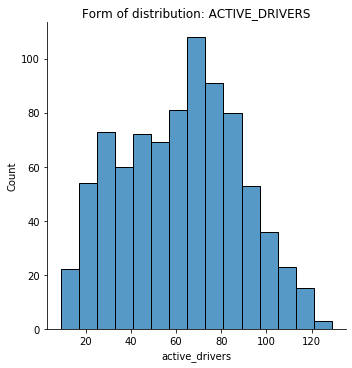

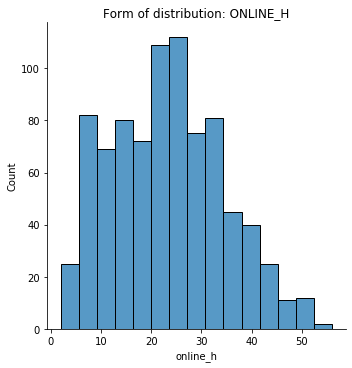

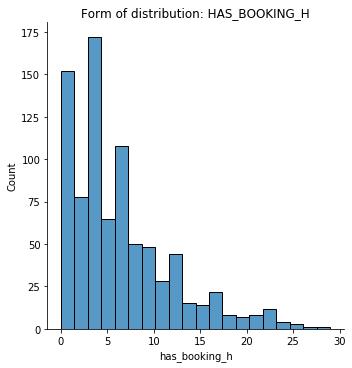

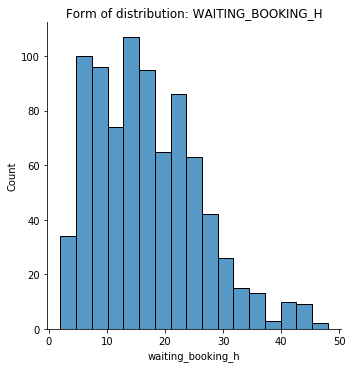

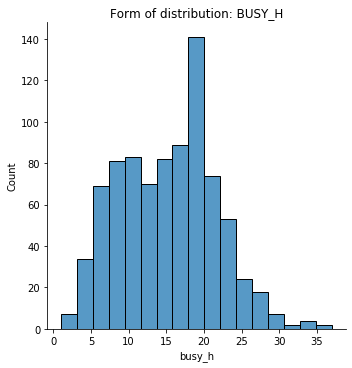

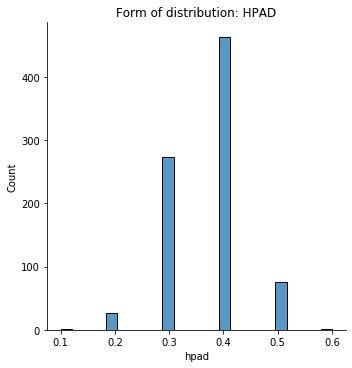

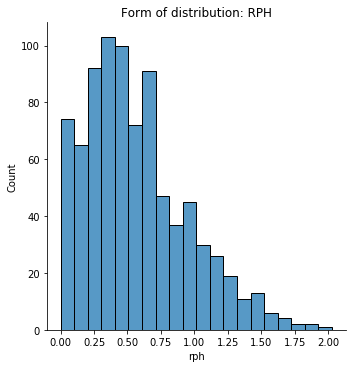

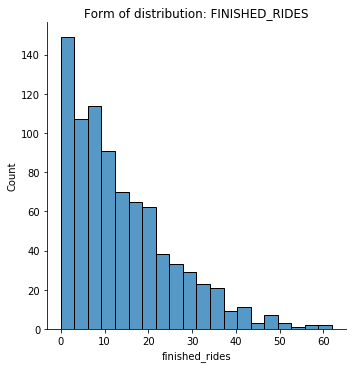

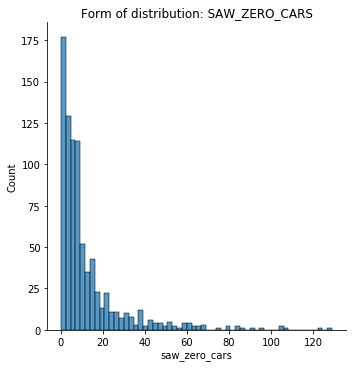

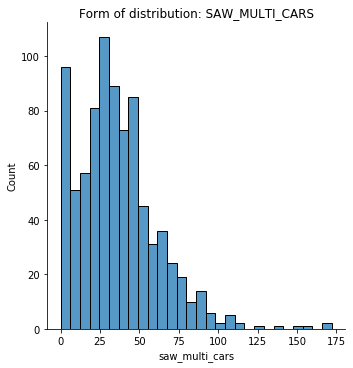

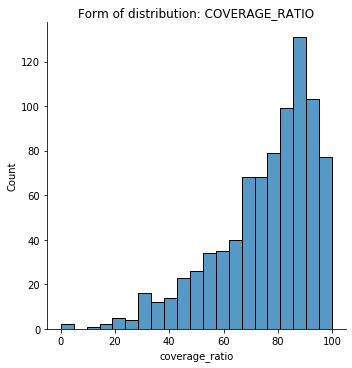

In [27]:
for col in df.columns[1:]:
    ax = sns.displot(df[col], kde=False).set(title=f'Form of distribution: {col.upper()}')

Let's visually check data for having outliers (values outside 1.5\*IQR).

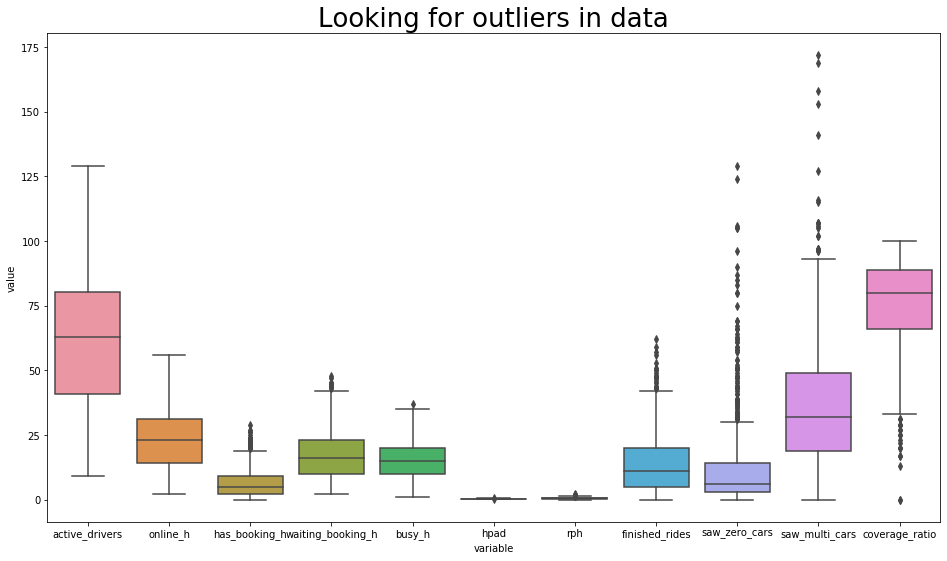

In [28]:
plt.rcParams["figure.figsize"] = (16, 9)
sns.boxplot(x="variable", y="value", data=pd.melt(df[df.columns[1:]])).set_title('Looking for outliers in data', fontsize=26);

We can see many outliers in `saw_zero_cars` column, it means that demand and supply are not always well balanced. Also we can see that sometimes `coverage_ratio` is way too low.

Finally, let's plot pairwise relationships in a dataset.

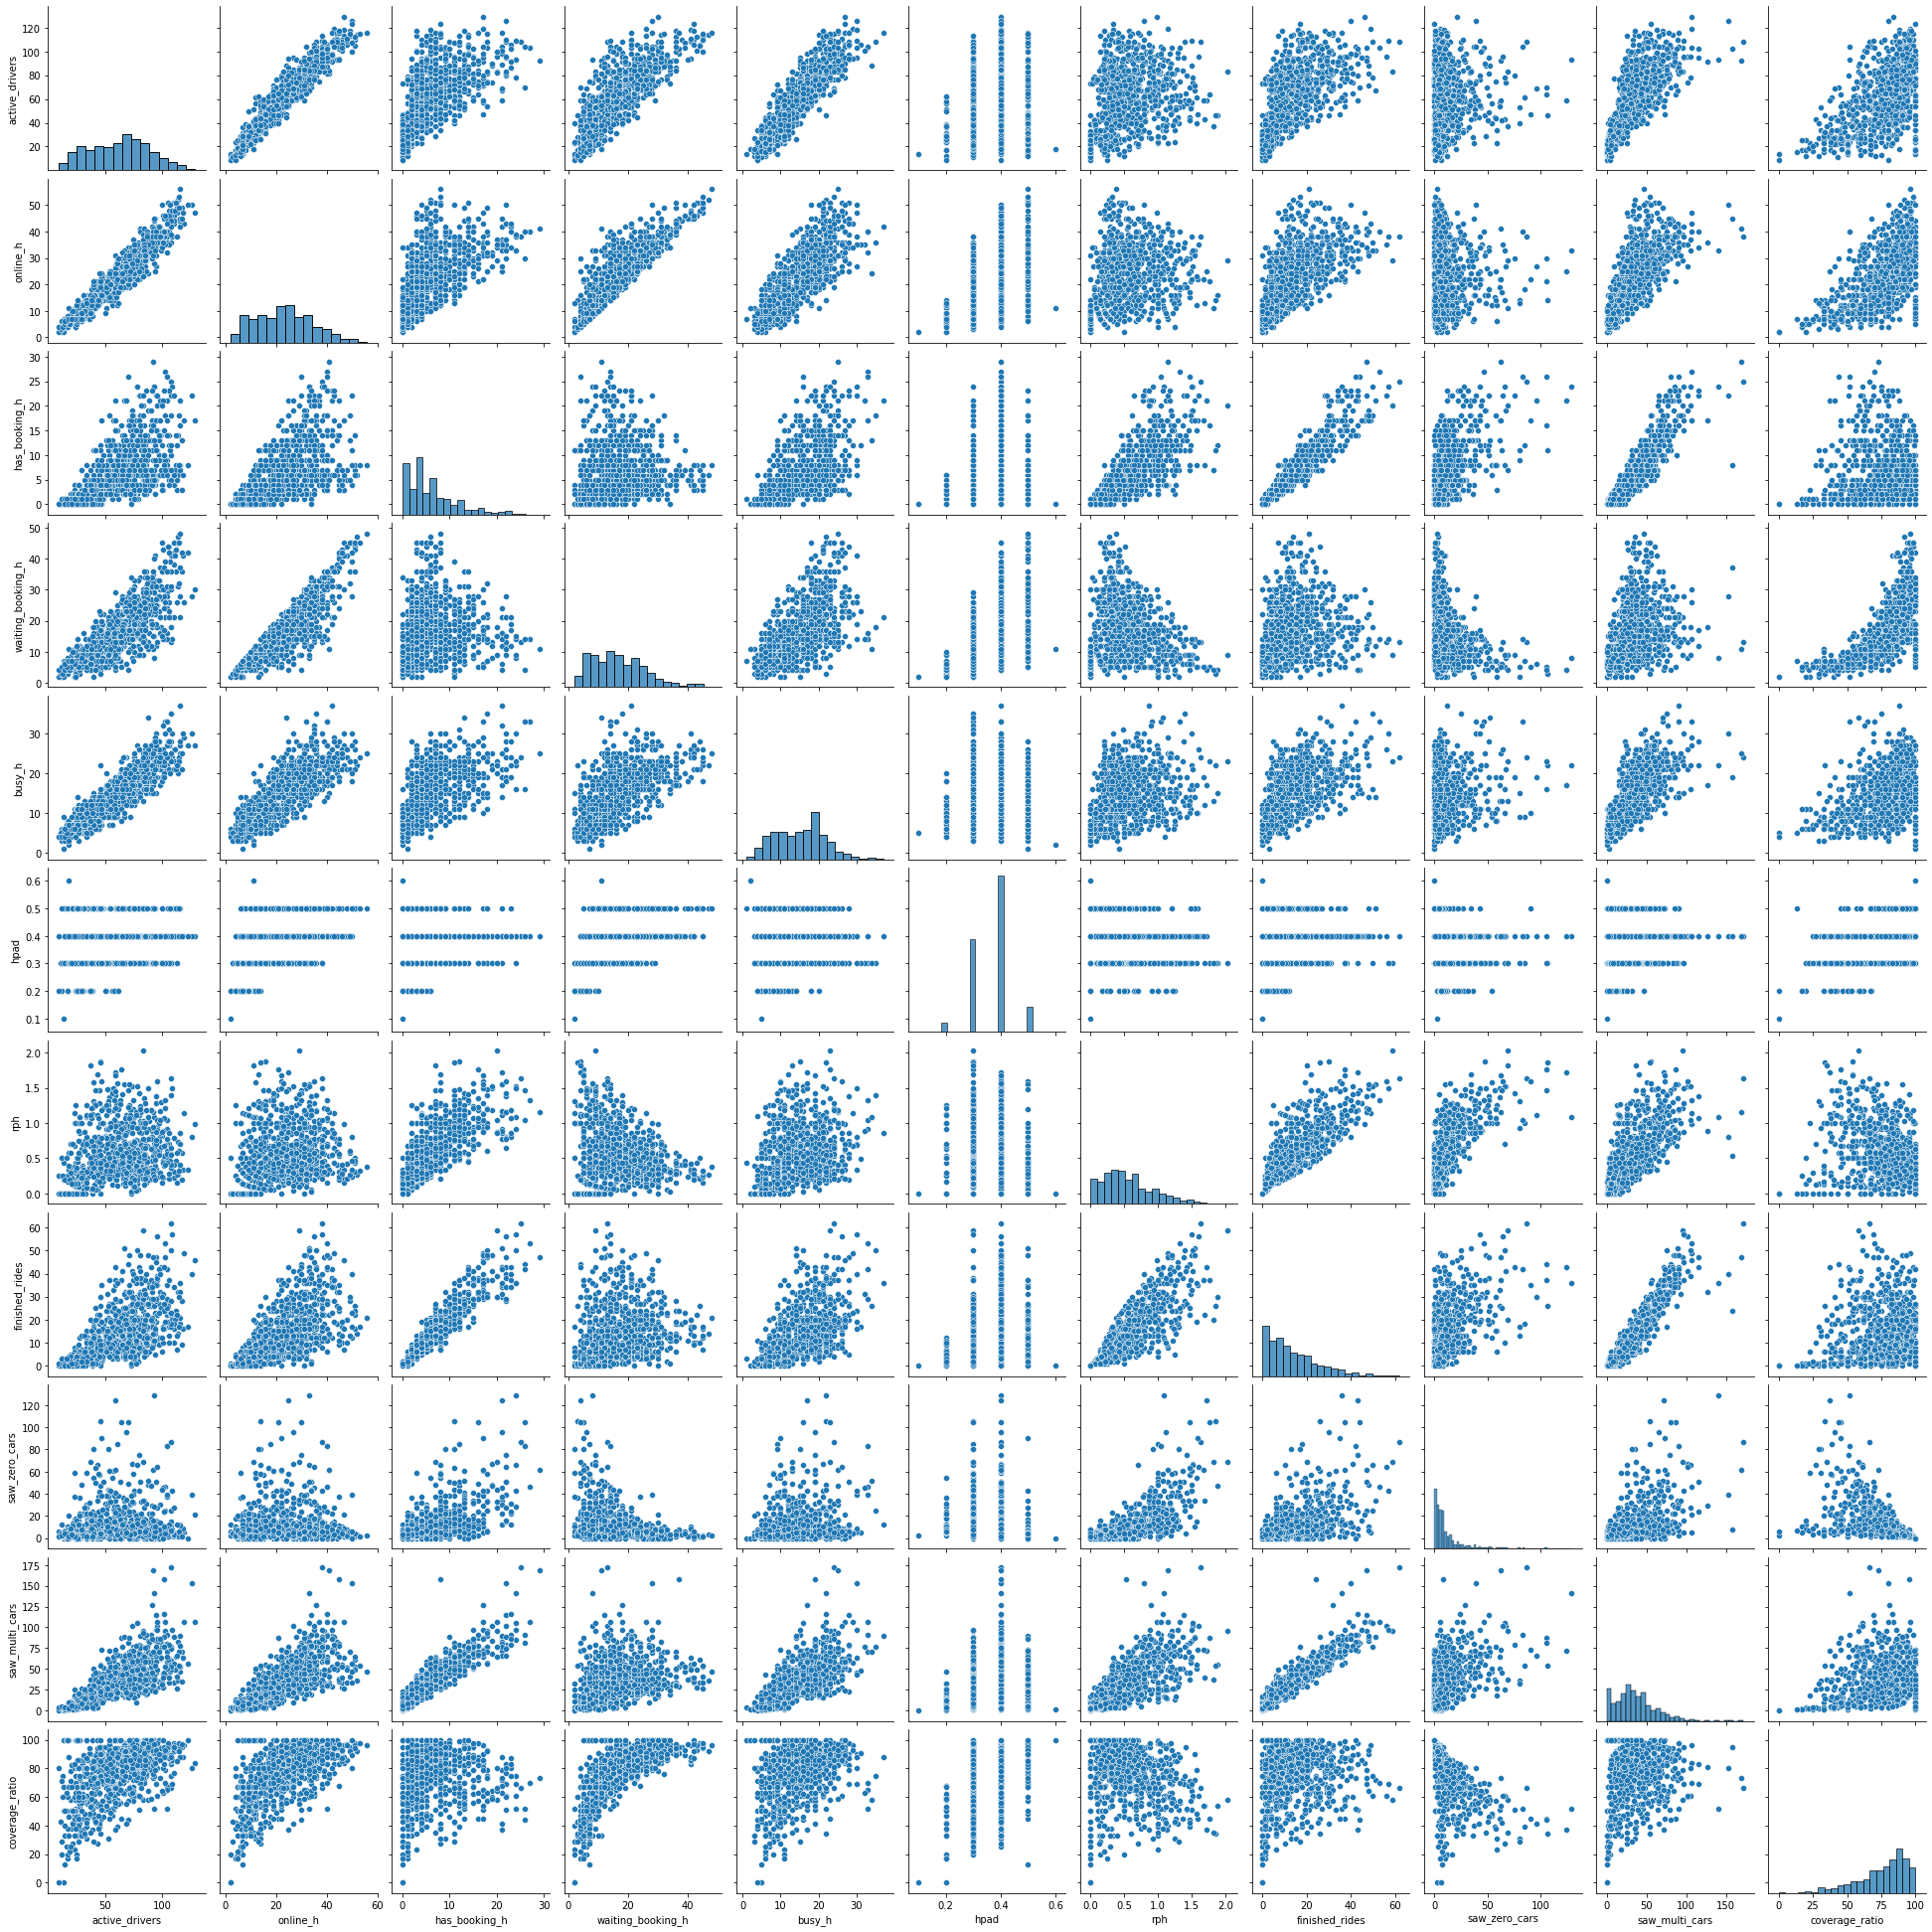

In [29]:
sns.pairplot(df[df.columns[1:]]);

We can see good correlations between some parameters. We'll investigate correlations that are of interest to us later.

Also sometimes there is a discrepancy in data: `waiting_booking_h` + `has_booking_h` are not always equal to `online_h`.

In [30]:
df['delta'] = df['online_h'] - (df['waiting_booking_h'] + df['has_booking_h'])

In [31]:
delta_values = df.delta.to_list()
print(*delta_values, sep=', ')

1, 0, 0, -1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, -1, 0, 0, -1, 0, -1, 1, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 1, 0, 0, 0, 0, -1, 0, 1, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 1, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, -1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0

As we can see it is always plus one hour delta or minus one hour delta. We'll assume that this is caused by rounding errors in data and data was logged correctly. But we have pay attention to such things when rounding.

In [32]:
# removing `delta` column, because we do not need it anymore
df.drop(columns=['delta'], inplace=True)

## Data Analysis

### Defining actual demand and supply

In [33]:
df.head()

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio
0,2016-12-18 23:00:00,52,18,6,11,11,0.30,0.67,12,9.00,32.00,78.00
1,2016-12-18 22:00:00,59,20,11,9,12,0.30,1.40,28,29.00,64.00,69.00
2,2016-12-18 21:00:00,72,25,7,18,15,0.30,0.64,16,5.00,39.00,89.00
3,2016-12-18 20:00:00,86,29,7,23,15,0.30,0.52,15,13.00,48.00,79.00
4,2016-12-18 19:00:00,82,31,14,17,19,0.40,1.16,36,12.00,77.00,87.00


First we have to define what is supply and demand.  
Our supply is the number of finished rides we can perform during a given time period.

In [34]:
df['actual_supply'] = df['finished_rides']

Also we have to calculate actual_demand metrics (users who opened our app and were looking for a ride) that is equal to the sum of `saw_zero_cars`  and `saw_multi_cars`.

In [35]:
df['actual_demand'] = df['saw_zero_cars'] + df['saw_multi_cars']

Also we have to fill our missing value in `actual_demand` column with zero (time period when there were no customers at all).

In [36]:
# finding this line
df[df.actual_demand.isna() == 1]

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio,actual_supply,actual_demand
282,2016-12-07 05:00:00,24,8,0,8,10,0.30,0.00,0,nan,nan,nan,0,nan


In [37]:
# filling it with a zero value
df['actual_demand'] = df.actual_demand.fillna(0)

Calculating supply and demand difference. If the value is negative -- it means we are undersupply and we need more drivers to be available online, if this metric is positive, we have oversupply. Ideally we want to have this value around zero to be well-balanced by satisfying the demand and having minimal expenditures at the same time.

In [38]:
df['supply_demand_dif'] = df['actual_supply'] - df['actual_demand']

Now let's extract more details about dates we have.

In [39]:
df['day_of_year'] = df.date.dt.dayofyear

In [40]:
df['week_of_year'] = df.date.dt.weekofyear;

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [41]:
df['day_of_week'] = df.date.dt.day_name()

In [42]:
df['day_of_week_num'] = df.date.dt.dayofweek

In [43]:
df['hour'] = df.date.dt.hour

Let's have a look at data we have now after all manipulations we did:

In [44]:
df

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio,actual_supply,actual_demand,supply_demand_dif,day_of_year,week_of_year,day_of_week,day_of_week_num,hour
0,2016-12-18 23:00:00,52,18,6,11,11,0.30,0.67,12,9.00,32.00,78.00,12,41.00,-29.00,353,50,Sunday,6,23
1,2016-12-18 22:00:00,59,20,11,9,12,0.30,1.40,28,29.00,64.00,69.00,28,93.00,-65.00,353,50,Sunday,6,22
2,2016-12-18 21:00:00,72,25,7,18,15,0.30,0.64,16,5.00,39.00,89.00,16,44.00,-28.00,353,50,Sunday,6,21
3,2016-12-18 20:00:00,86,29,7,23,15,0.30,0.52,15,13.00,48.00,79.00,15,61.00,-46.00,353,50,Sunday,6,20
4,2016-12-18 19:00:00,82,31,14,17,19,0.40,1.16,36,12.00,77.00,87.00,36,89.00,-53.00,353,50,Sunday,6,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2016-11-14 04:00:00,15,6,0,6,6,0.40,0.00,0,4.00,4.00,50.00,0,8.00,-8.00,319,46,Monday,0,4
836,2016-11-14 03:00:00,18,7,0,7,7,0.40,0.00,0,1.00,2.00,67.00,0,3.00,-3.00,319,46,Monday,0,3
837,2016-11-14 02:00:00,21,7,0,7,9,0.30,0.14,1,3.00,6.00,67.00,1,9.00,-8.00,319,46,Monday,0,2
838,2016-11-14 01:00:00,29,9,1,8,11,0.30,0.22,2,8.00,8.00,50.00,2,16.00,-14.00,319,46,Monday,0,1


### Demand and Supply during a week

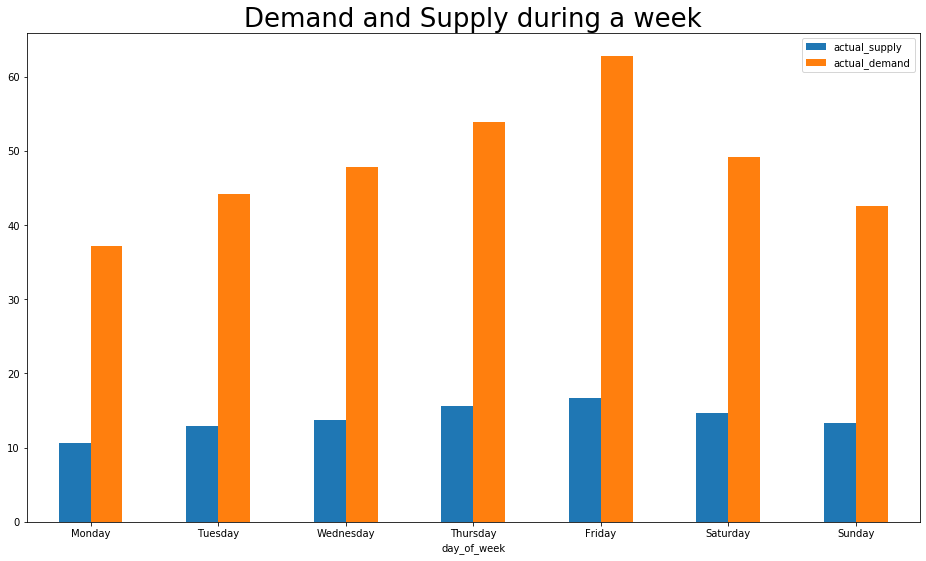

In [45]:
fig = df.groupby(['day_of_week_num', 'day_of_week'], as_index=False) \
    .agg({'actual_demand': 'mean', 'actual_supply': 'mean'}).drop(columns={'day_of_week_num'}) \
    .plot(kind='bar', x='day_of_week', y=['actual_supply', 'actual_demand'],
          title='Demand and Supply during a week', rot=0)

fig.axes.title.set_size(26);

### Which 36 hours in a week are most undersupplied

A list of the most undersupplied 36 hours in a week sorted from the most undersupplied hours to the least undersupplied hours (Top-36).

In [46]:
df.groupby(['day_of_week', 'hour'], as_index=False) \
    .agg({'supply_demand_dif': 'mean'}) \
    .sort_values('supply_demand_dif').head(36).reset_index(drop=True)

,day_of_week,hour,supply_demand_dif
0,Thursday,18,-95.40
1,Friday,19,-91.40
2,Friday,18,-84.60
3,Thursday,19,-84.00
4,Wednesday,18,-81.40
5,Friday,20,-79.60
6,Friday,9,-75.20
7,Tuesday,18,-75.00
8,Friday,21,-70.00
9,Wednesday,19,-68.80


We can re-sort this table by day of week and hour to see clusters of periods with highest supply shortage.

In [270]:
f = {'supply_demand_dif':'{:.2f}'}

df.groupby(['day_of_week_num', 'day_of_week', 'hour'], as_index=False) \
    .agg({'supply_demand_dif': 'mean'}) \
    .sort_values('supply_demand_dif').head(36).reset_index(drop=True) \
    .sort_values(['day_of_week_num', 'hour']) \
    .drop(columns=['day_of_week_num']).reset_index(drop=True) \
    .style.format(f).bar(subset=['supply_demand_dif'], color='#d65f5f', align='zero')

,day_of_week,hour,supply_demand_dif
0,Monday,8,-52.20
1,Monday,9,-58.60
2,Monday,19,-49.00
3,Tuesday,8,-57.60
4,Tuesday,9,-65.40
5,Tuesday,18,-75.00
6,Tuesday,19,-64.80
7,Wednesday,8,-54.60
8,Wednesday,9,-62.80
9,Wednesday,17,-68.60


The most severe undersupply can be seen on:
* Friday 6-9 pm, 
* Thursday 5-8 pm,
* Wednesday 5-7 pm,
* Friday 8-10 am 

### 24-hour curve of average supply and demand

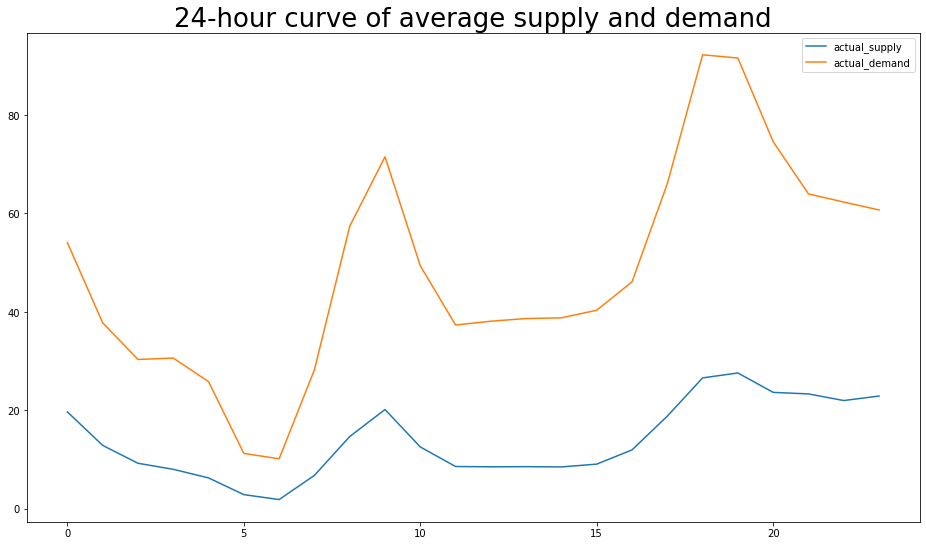

In [48]:
df.groupby(['hour'], as_index=False) \
    .agg({'actual_supply': 'mean', 'actual_demand': 'mean'})[['actual_supply', 'actual_demand']].plot(kind='line')
plt.title('24-hour curve of average supply and demand', fontsize=26);

### Visualisation of hours where we lack supply during a weekly period

Visualizing the results we have.

In [49]:
# data to viz
supl_week_agg = df.groupby(['day_of_week_num', 'hour'], as_index=False) \
    .agg({'supply_demand_dif': 'mean'}) \
    .sort_values(['day_of_week_num', 'hour']).reset_index()

Supply-demand difference by day (Monday = 0, Tuesday = 1, etc.)

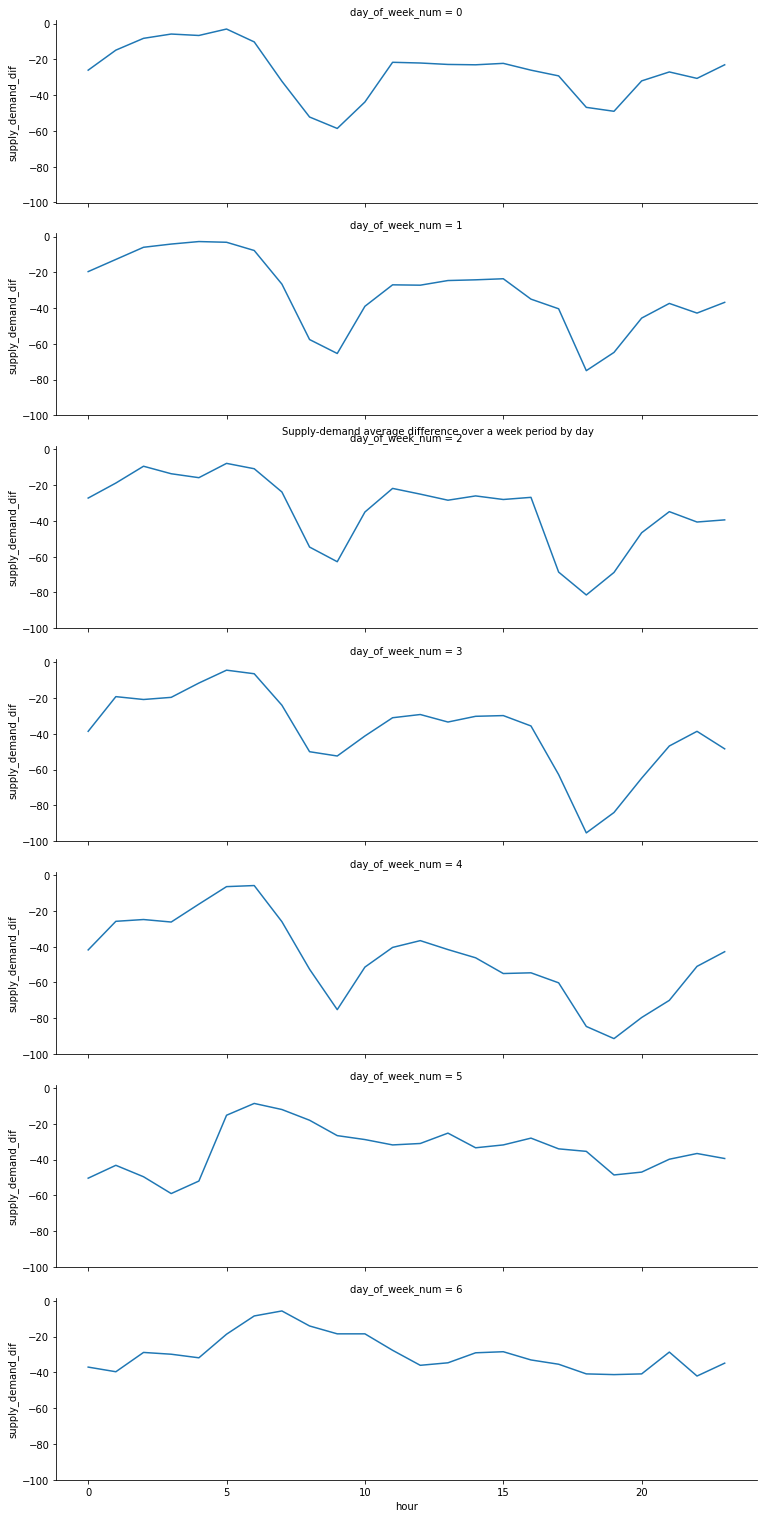

In [50]:
ax = sns.relplot(
    data=supl_week_agg, 
    x='hour', y='supply_demand_dif', row='day_of_week_num',
    height=3, aspect=3.5,
    kind='line'
    );
plt.text(x=7.0, y=485, s='Supply-demand average difference over a week period by day');

Same, but all days are overlaid on one graph.

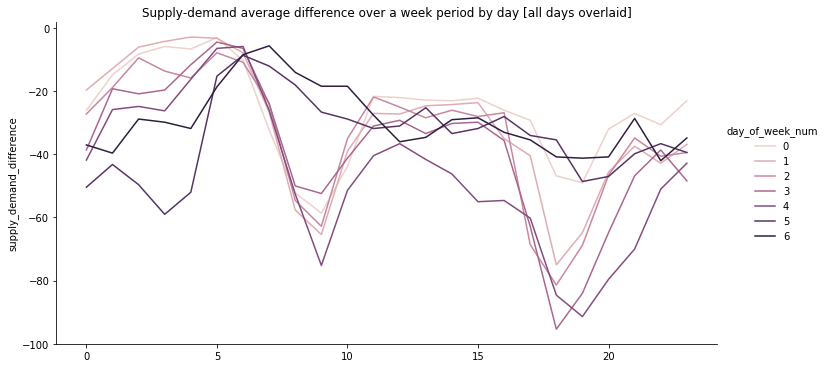

In [51]:
sns.relplot(
    data=supl_week_agg, 
    x='hour', y='supply_demand_dif', hue='day_of_week_num',
    height=5,
    aspect=2, 
    kind='line'
).set(
    title='Supply-demand average difference over a week period by day [all days overlaid]', 
    ylabel='supply_demand_difference',
    xlabel=None);

Supply-demand difference over a week period aggregated data by day and hour of the day.

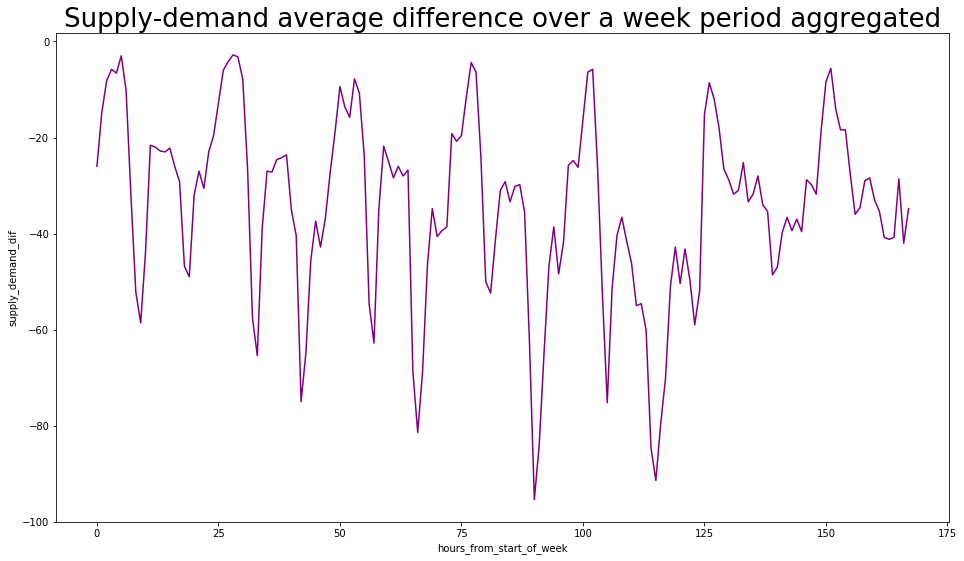

In [52]:
sns.lineplot(data=supl_week_agg, x='index', y='supply_demand_dif', color='purple') \
    .set_title('Supply-demand average difference over a week period aggregated', fontsize=26)
plt.xlabel('hours_from_start_of_week');

The most severe undersupply can be seen on:
* Friday 6-9 pm, 
* Thursday 5-8 pm,
* Wednesday 5-7 pm,
* Friday 8-10 am 

### Number of hours needed to ensure we can meet all the demand

Calculating average ride duration.

In [53]:
df['ride_duration'] = df['has_booking_h'] / df['finished_rides']

Looking for inf values. Division by zero when there is an ongoing ride  but it was not finished during the given time interval.

In [54]:
df[df['ride_duration'] == np.inf]

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio,actual_supply,actual_demand,supply_demand_dif,day_of_year,week_of_year,day_of_week,day_of_week_num,hour,ride_duration
16,2016-12-18 07:00:00,28,9,1,8,11,0.30,0.00,0,1.00,4.00,80.00,0,5.00,-5.00,353,50,Sunday,6,7,inf
91,2016-12-15 04:00:00,21,6,1,5,4,0.30,0.00,0,5.00,3.00,38.00,0,8.00,-8.00,350,50,Thursday,3,4,inf
115,2016-12-14 04:00:00,14,5,1,4,6,0.40,0.00,0,3.00,3.00,50.00,0,6.00,-6.00,349,50,Wednesday,2,4,inf
184,2016-12-11 07:00:00,25,11,1,10,8,0.40,0.00,0,3.00,5.00,63.00,0,8.00,-8.00,346,49,Sunday,6,7,inf
334,2016-12-05 01:00:00,31,10,1,10,7,0.30,0.00,0,4.00,12.00,75.00,0,16.00,-16.00,340,49,Monday,0,1,inf
370,2016-12-03 13:00:00,73,31,1,30,12,0.40,0.00,0,3.00,17.00,85.00,0,20.00,-20.00,338,48,Saturday,5,13,inf
762,2016-11-17 05:00:00,28,10,1,9,10,0.40,0.00,0,1.00,3.00,75.00,0,4.00,-4.00,322,46,Thursday,3,5,inf


Substituting such inf values by 1 (ride duration of 1 hour - ride is still in process and wasn't finished).

In [55]:
df.replace([np.inf, -np.inf], 1, inplace=True)

Looking for NaN values (when there were no recorded has_booking_h and no finished rides).

In [56]:
df[df['ride_duration'].isna() == 1].head(5)

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio,actual_supply,actual_demand,supply_demand_dif,day_of_year,week_of_year,day_of_week,day_of_week_num,hour,ride_duration
65,2016-12-16 06:00:00,17,4,0,3,5,0.20,0.00,0,2.00,3.00,60.00,0,5.00,-5.00,351,50,Friday,4,6,nan
114,2016-12-14 05:00:00,17,6,0,6,6,0.40,0.00,0,2.00,3.00,60.00,0,5.00,-5.00,349,50,Wednesday,2,5,nan
138,2016-12-13 05:00:00,13,4,0,4,5,0.30,0.00,0,1.00,3.00,75.00,0,4.00,-4.00,348,50,Tuesday,1,5,nan
139,2016-12-13 04:00:00,16,5,0,5,5,0.30,0.00,0,0.00,1.00,100.00,0,1.00,-1.00,348,50,Tuesday,1,4,nan
140,2016-12-13 03:00:00,14,5,0,4,6,0.40,0.00,0,1.00,2.00,67.00,0,3.00,-3.00,348,50,Tuesday,1,3,nan


In [57]:
df.ride_duration.isna().sum()

38

Substituting NaN with average ride duration.

In [58]:
# calculating average_ride_duration
avg_ride_duration = df[df['ride_duration'].isna() == 0].ride_duration.mean()

avg_ride_duration

0.4557127725699744

In [59]:
# substituting values
df.ride_duration.fillna(value=avg_ride_duration,inplace=True)

Looking for cases when `has_booking_h` is zero, but we have actually finished_rides. Can happen because of an error of rounding for the `has_booking_h` field.

In [60]:
df[df['ride_duration'] == 0].head(3)

,date,active_drivers,online_h,has_booking_h,waiting_booking_h,busy_h,hpad,rph,finished_rides,saw_zero_cars,saw_multi_cars,coverage_ratio,actual_supply,actual_demand,supply_demand_dif,day_of_year,week_of_year,day_of_week,day_of_week_num,hour,ride_duration
89,2016-12-15 06:00:00,23,9,0,9,4,0.40,0.11,1,2.00,2.00,50.00,1,4.00,-3.00,350,50,Thursday,3,6,0.00
113,2016-12-14 06:00:00,24,6,0,6,7,0.30,0.33,2,1.00,3.00,75.00,2,4.00,-2.00,349,50,Wednesday,2,6,0.00
116,2016-12-14 03:00:00,12,2,0,2,6,0.20,0.50,1,12.00,3.00,20.00,1,15.00,-14.00,349,50,Wednesday,2,3,0.00


Substituting with average ride duration.

In [61]:
df.ride_duration.replace([0], avg_ride_duration, inplace=True)

Calculating the `ideal_has_booking_h` -- the number of total hours during which drivers have a client booking we want to have to satisfy all the demand we have.

In [62]:
df['ideal_has_booking_h'] = df['actual_demand'] * df['ride_duration']

Knowing the `ideal_has_booking_h` and the ratio of drivers `has_booking_h` and `waiting_booking_h` we can estimate the supposed number of waiting_booking_h for the estimated ideal_has_booking_h.

In [63]:
df['ideal_waiting_booking_h'] = df['ideal_has_booking_h'] / (df['has_booking_h'] / df['waiting_booking_h'])

We'll replace inf values (because of having zeroes in `has_booking_h` due to the rounding mistake with `has_booking_h` / `waiting_booking_h` ratio average value.

In [64]:
# calculating average book_wait_ratio
df['book_wait_ratio'] = df['has_booking_h'] / df['waiting_booking_h']
avg_book_wait = df['book_wait_ratio'].mean()

avg_book_wait

0.47561174159826924

In [65]:
# making replacement of inf values
temp_lst = []
for index, row in df.iterrows():
    if df.iloc[index].ideal_waiting_booking_h == np.inf:
        temp_lst.append(df.iloc[index].ideal_has_booking_h / avg_book_wait)
    else:
        temp_lst.append(df.iloc[index].ideal_waiting_booking_h)

df['ideal_waiting_booking_h'] = temp_lst

Finally, let's define `ideal_online_h` to satisfy all the demand we have that will be a sum of `ideal_has_booking_h` and `ideal_waiting_booking_h`.

In [66]:
df['ideal_online_h'] = df['ideal_has_booking_h'] + df['ideal_waiting_booking_h']

Now we can query for the most 36 peak hours and see the results of our ideal_online_h estimation to meet all the demand we have.

In [67]:
most_peak_h = df.groupby(['day_of_week_num', 'day_of_week', 'hour'], as_index=False) \
    .agg({'actual_demand': 'mean',
          'online_h': 'mean',
          'ideal_online_h': 'mean'}) \
    .sort_values(['actual_demand'], ascending=False).head(36) 

Calculating extra online hours required to meet all the demand we have.

In [72]:
most_peak_h['extra_online_h_required'] = most_peak_h['ideal_online_h'] - most_peak_h['online_h']

In [74]:
f = {'online_h':'{:.2f}',
     'actual_demand':'{:.2f}',
     'ideal_online_h':'{:.2f}',
     'extra_online_h_required':'{:.2f}'}

most_peak_h.sort_values(['day_of_week_num', 'hour']) \
    .drop(columns='day_of_week_num').reset_index(drop=True) \
    .style.format(f) \
    .bar(subset=['actual_demand'], color=['#98FB98'], align='left') \
    .bar(subset=['extra_online_h_required'], color=['#FFC0CB'], align='left')

,day_of_week,hour,actual_demand,online_h,ideal_online_h,extra_online_h_required
0,Monday,8,71.80,18.60,66.59,47.99
1,Monday,9,84.00,24.40,79.46,55.06
2,Monday,18,76.60,32.40,84.38,51.98
3,Monday,19,73.40,37.20,113.99,76.79
4,Tuesday,8,79.20,22.00,77.52,55.52
5,Tuesday,9,92.80,27.80,91.61,63.81
6,Tuesday,18,104.20,31.40,112.46,81.06
7,Tuesday,19,96.80,39.60,121.63,82.03
8,Wednesday,8,71.60,23.20,116.43,93.23
9,Wednesday,9,88.80,27.80,94.75,66.95


### Number of hours needed to ensure we have a high Coverage Ratio on peak hours daily

Monday.

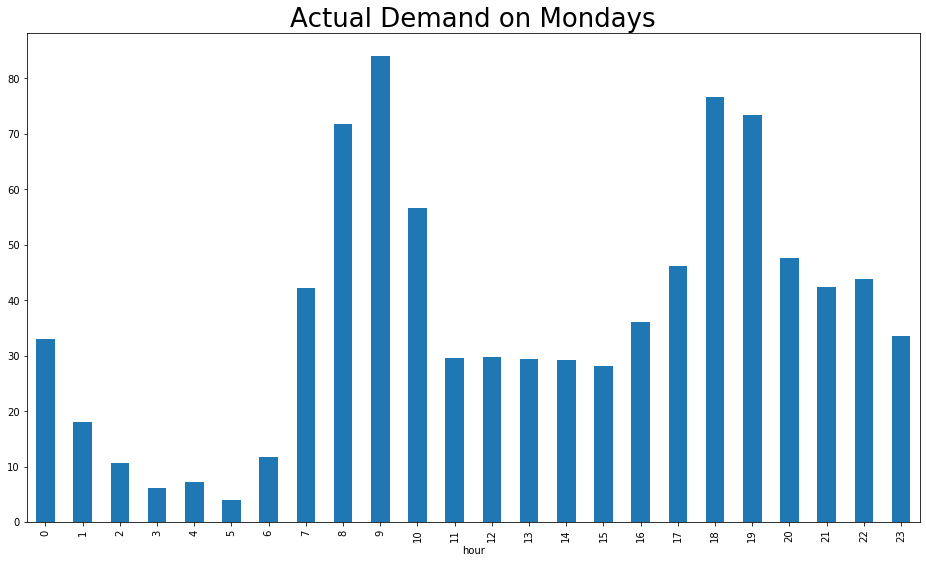

In [126]:
fig = df[df['day_of_week'] == 'Monday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Mondays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 40 we have peak hours.

Building a linear regression model for the current day peak hours.

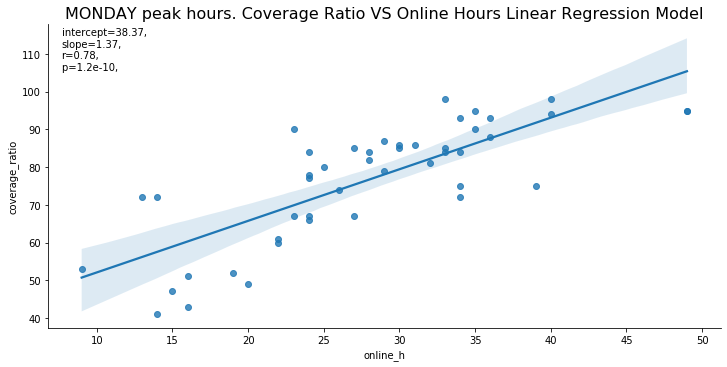

In [129]:
data = df[(df['day_of_week'] == 'Monday') & (df['actual_demand'] > 40)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('MONDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

In [142]:
# define dictionaries to store present average online_h and ideal onlin_h eestimation for peak hours for every day of a week
peak_hours_ideal_online_h = dict()
peak_hours_avg_online_h = dict()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [143]:
peak_hours_ideal_online_h['Monday'] = round((100 - 38.37) / 1.37, 2)

In [144]:
peak_hours_ideal_online_h

{'Monday': 44.99}

In [145]:
avg_online_h = round(df[(df['day_of_week'] == 'Monday') & (df['actual_demand'] > 40)].online_h.mean(), 2)
peak_hours_avg_online_h['Monday'] = avg_online_h

In [146]:
peak_hours_avg_online_h

{'Monday': 27.87}

Tuesday.

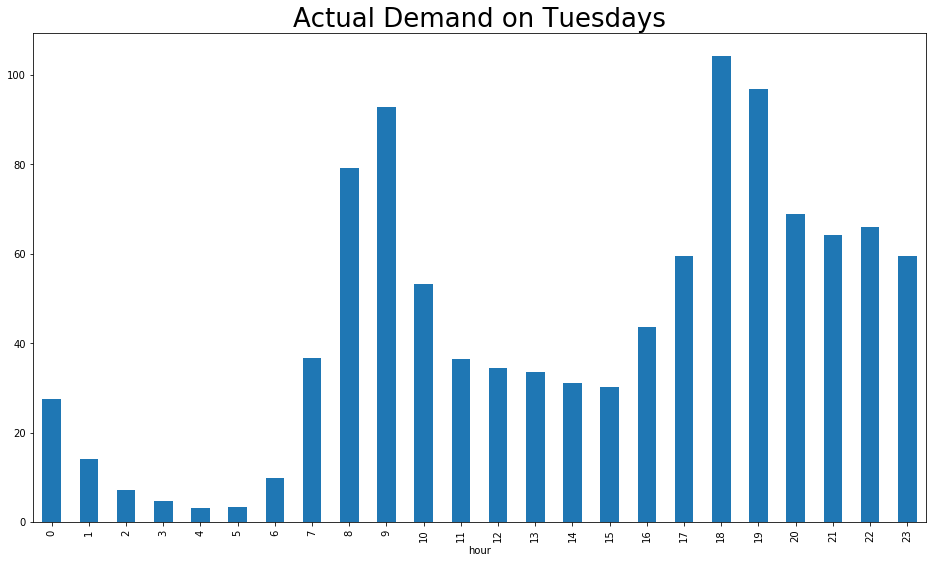

In [150]:
fig = df[df['day_of_week'] == 'Tuesday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Tuesdays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 50 we have peak hours.

Building a linear regression model for the current day peak hours.

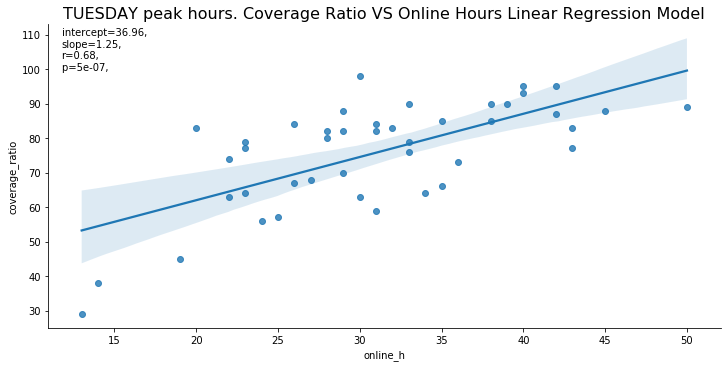

In [151]:
data = df[(df['day_of_week'] == 'Tuesday') & (df['actual_demand'] > 50)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('TUESDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [152]:
peak_hours_ideal_online_h['Tuesday'] = round((100 - 36.96) / 1.25, 2)

In [153]:
peak_hours_ideal_online_h

{'Monday': 44.99, 'Tuesday': 50.43}

In [154]:
avg_online_h = round(df[(df['day_of_week'] == 'Tuesday') & (df['actual_demand'] > 50)].online_h.mean(), 2)
peak_hours_avg_online_h['Tuesday'] = avg_online_h

In [155]:
peak_hours_avg_online_h

{'Monday': 27.87, 'Tuesday': 31.02}

Wednesday.

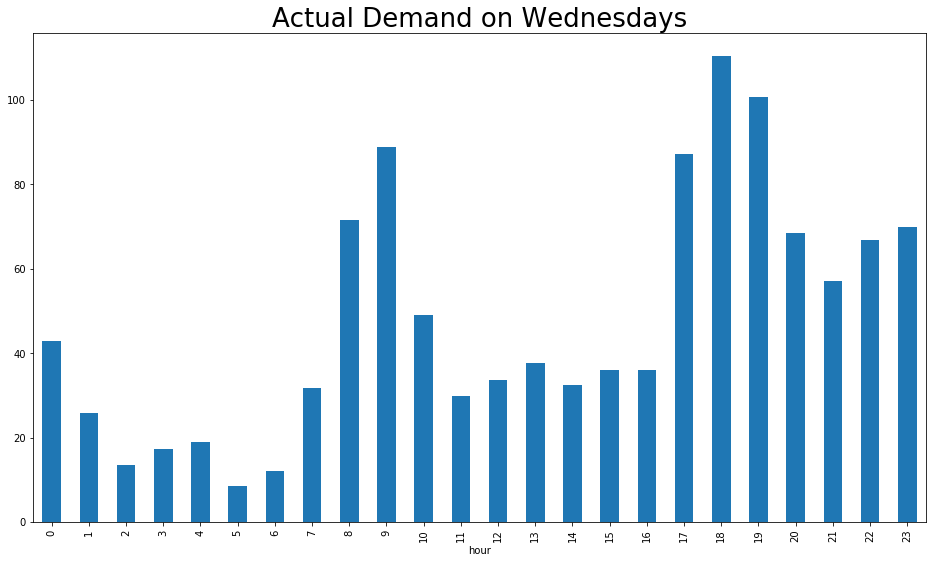

In [156]:
fig = df[df['day_of_week'] == 'Wednesday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Wednesdays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 50 we have peak hours.

Building a linear regression model for the current day peak hours.

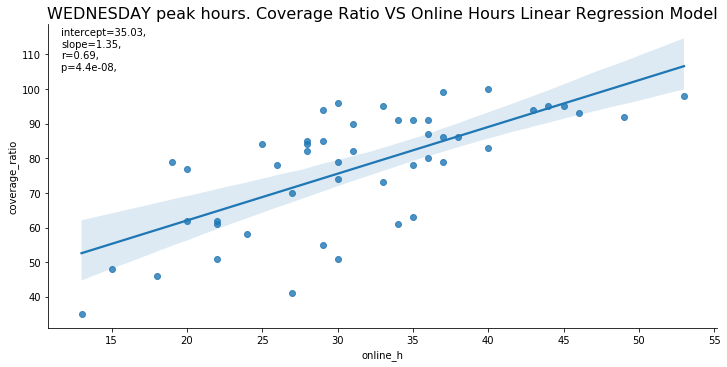

In [157]:
data = df[(df['day_of_week'] == 'Wednesday') & (df['actual_demand'] > 50)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('WEDNESDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [158]:
peak_hours_ideal_online_h['Wednesday'] = round((100 - 35.03) / 1.35, 2)

In [159]:
peak_hours_ideal_online_h

{'Monday': 44.99, 'Tuesday': 50.43, 'Wednesday': 48.13}

In [160]:
avg_online_h = round(df[(df['day_of_week'] == 'Wednesday') & (df['actual_demand'] > 50)].online_h.mean(), 2)
peak_hours_avg_online_h['Wednesday'] = avg_online_h

In [161]:
peak_hours_avg_online_h

{'Monday': 27.87, 'Tuesday': 31.02, 'Wednesday': 31.44}

Thursday.

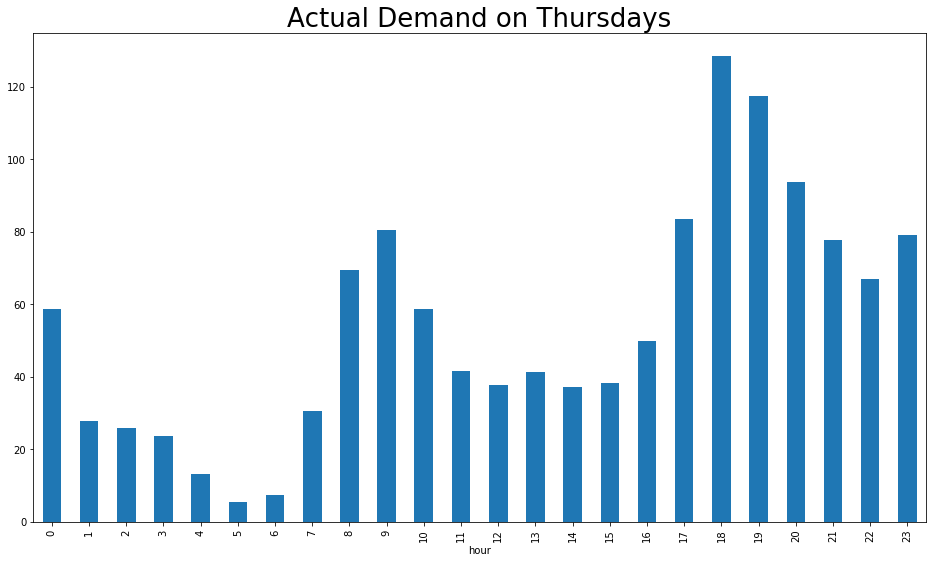

In [162]:
fig = df[df['day_of_week'] == 'Thursday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Thursdays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 50 we have peak hours.

Building a linear regression model for the current day peak hours.

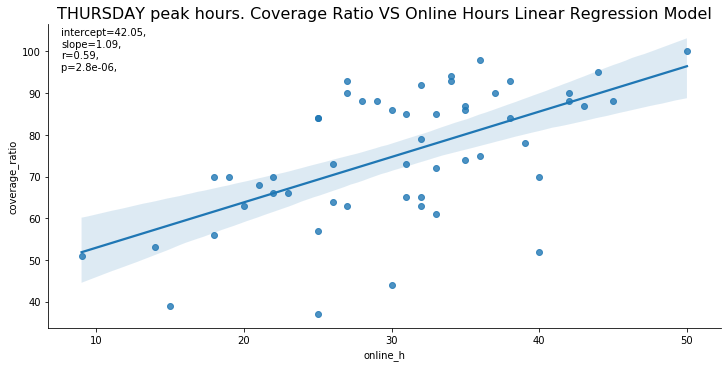

In [163]:
data = df[(df['day_of_week'] == 'Thursday') & (df['actual_demand'] > 50)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('THURSDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [164]:
peak_hours_ideal_online_h['Thursday'] = round((100 - 42.05) / 1.09, 2)

In [165]:
peak_hours_ideal_online_h

{'Monday': 44.99, 'Tuesday': 50.43, 'Wednesday': 48.13, 'Thursday': 53.17}

In [166]:
avg_online_h = round(df[(df['day_of_week'] == 'Thursday') & (df['actual_demand'] > 50)].online_h.mean(), 2)
peak_hours_avg_online_h['Thursday'] = avg_online_h

In [167]:
peak_hours_avg_online_h

{'Monday': 27.87, 'Tuesday': 31.02, 'Wednesday': 31.44, 'Thursday': 30.45}

Friday.

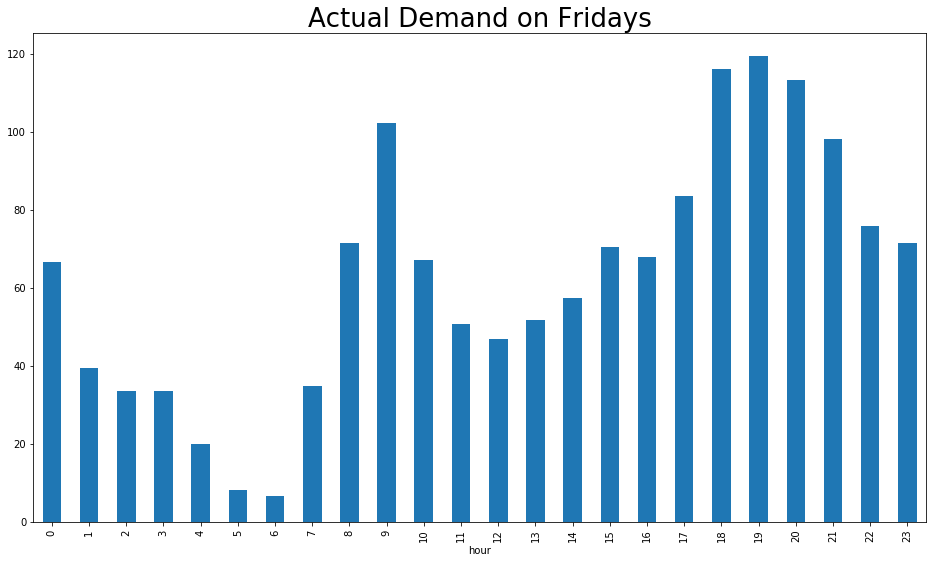

In [168]:
fig = df[df['day_of_week'] == 'Friday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Fridays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 60 we have peak hours.

Building a linear regression model for the current day peak hours.

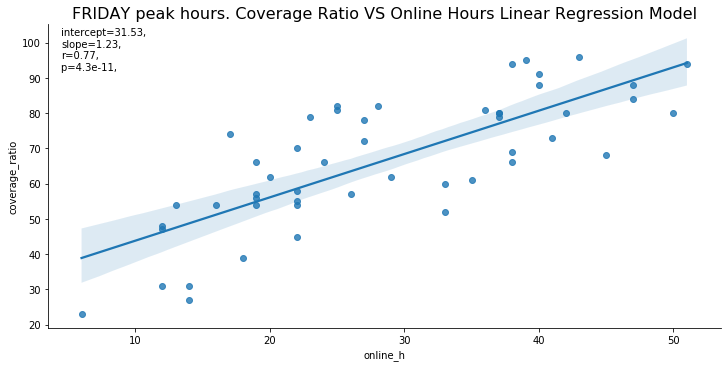

In [169]:
data = df[(df['day_of_week'] == 'Friday') & (df['actual_demand'] > 60)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('FRIDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [170]:
peak_hours_ideal_online_h['Friday'] = round((100 - 31.53) / 1.23, 2)

In [171]:
peak_hours_ideal_online_h

{'Monday': 44.99,
 'Tuesday': 50.43,
 'Wednesday': 48.13,
 'Thursday': 53.17,
 'Friday': 55.67}

In [182]:
avg_online_h = round(df[(df['day_of_week'] == 'Friday') & (df['actual_demand'] > 60)].online_h.mean(), 2)
peak_hours_avg_online_h['Friday'] = avg_online_h

In [183]:
peak_hours_avg_online_h

{'Monday': 27.87,
 'Tuesday': 31.02,
 'Wednesday': 31.44,
 'Thursday': 30.45,
 'Friday': 28.42,
 'Saturday': 28.85}

Saturday.

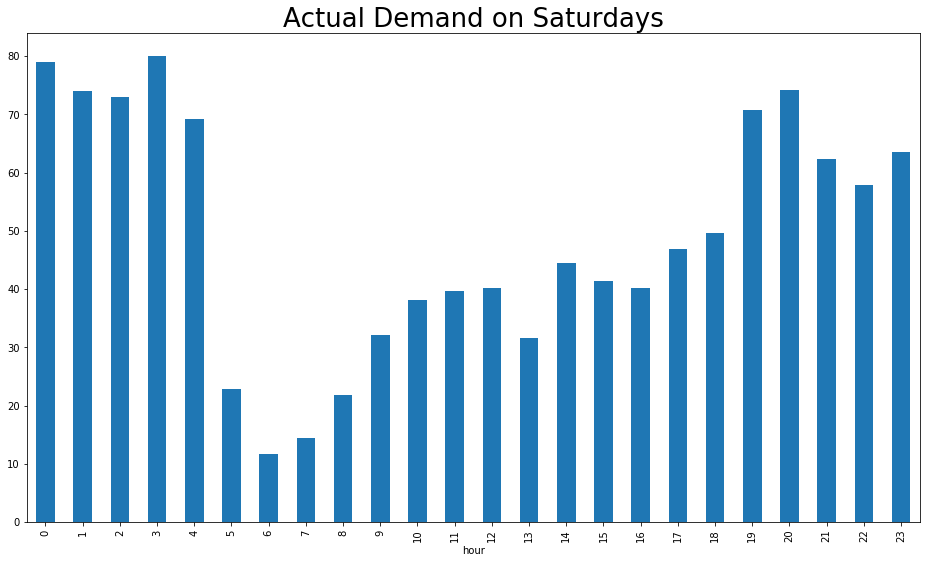

In [174]:
fig = df[df['day_of_week'] == 'Saturday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Saturdays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 50 we have peak hours.

Building a linear regression model for the current day peak hours.

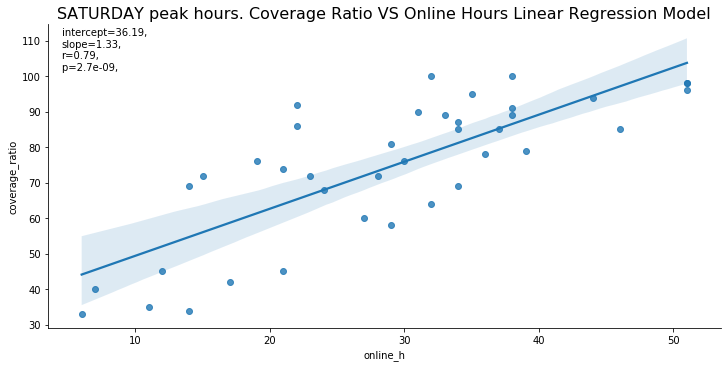

In [175]:
data = df[(df['day_of_week'] == 'Saturday') & (df['actual_demand'] > 50)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('SATURDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [176]:
peak_hours_ideal_online_h['Saturday'] = round((100 - 36.19) / 1.33, 2)

In [177]:
peak_hours_ideal_online_h

{'Monday': 44.99,
 'Tuesday': 50.43,
 'Wednesday': 48.13,
 'Thursday': 53.17,
 'Friday': 55.67,
 'Saturday': 47.98}

In [184]:
avg_online_h = round(df[(df['day_of_week'] == 'Saturday') & (df['actual_demand'] > 50)].online_h.mean(), 2)
peak_hours_avg_online_h['Saturday'] = avg_online_h

In [185]:
peak_hours_avg_online_h

{'Monday': 27.87,
 'Tuesday': 31.02,
 'Wednesday': 31.44,
 'Thursday': 30.45,
 'Friday': 28.42,
 'Saturday': 28.85}

Sunday.

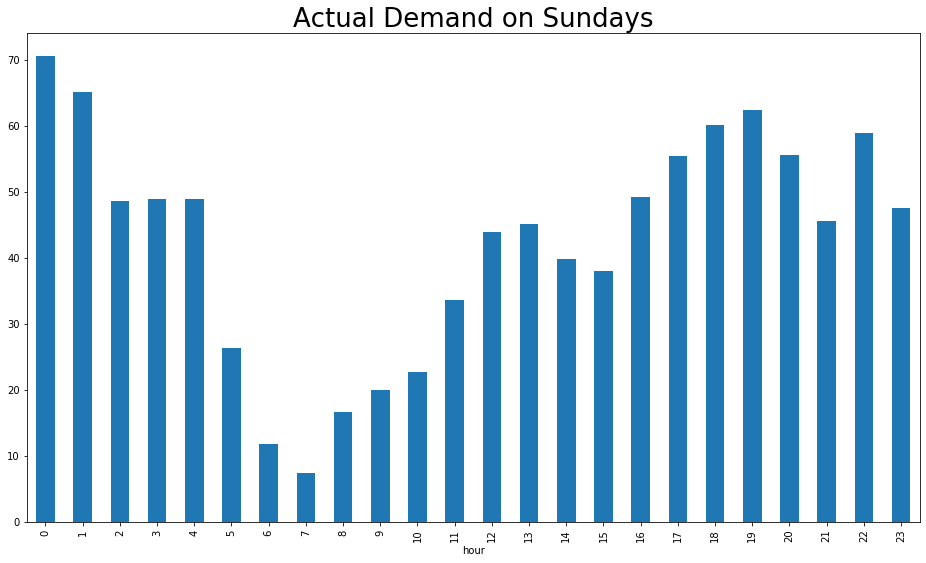

In [186]:
fig = df[df['day_of_week'] == 'Sunday'].groupby('hour') \
    .agg({'actual_demand': 'mean'}) \
    .actual_demand.plot(kind='bar', title='Actual Demand on Sundays')

fig.axes.title.set_size(26);

After looking at the chart let's assume that when demand is above 45 we have peak hours.

Building a linear regression model for the current day peak hours.

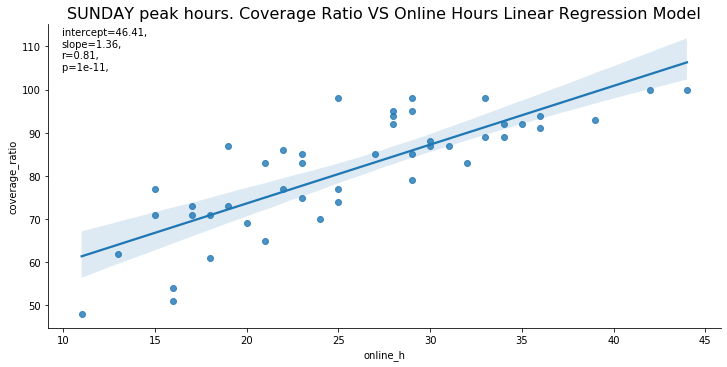

In [187]:
data = df[(df['day_of_week'] == 'Sunday') & (df['actual_demand'] > 45)]
g = sns.lmplot(x='online_h', y='coverage_ratio', 
               data=data, 
               height=5, aspect=2, fit_reg=True, )


def annotate(data, **kws):
    slope, intercept, r, p, se = linregress(data.online_h,
                                            data.coverage_ratio)
    ax = plt.gca()
    ax.text(.02, .85, 'intercept={:.2f},\nslope={:.2f},\nr={:.2f},\np={:.2g}, '.format(intercept, slope, r, p),
            transform=ax.transAxes)
    ax.set_title('SUNDAY peak hours. Coverage Ratio VS Online Hours Linear Regression Model', fontsize=16)

    
g.map_dataframe(annotate)
g.set(xlabel='online_h', ylabel='coverage_ratio')
plt.show()

Now when we have intercept, slope and a significant strong correlation we can estimate the number of online hours we need to have 100% coverage during online hours.

In [188]:
peak_hours_ideal_online_h['Sunday'] = round((100 - 46.41) / 1.36, 2)

In [189]:
peak_hours_ideal_online_h

{'Monday': 44.99,
 'Tuesday': 50.43,
 'Wednesday': 48.13,
 'Thursday': 53.17,
 'Friday': 55.67,
 'Saturday': 47.98,
 'Sunday': 39.4}

In [190]:
avg_online_h = round(df[(df['day_of_week'] == 'Sunday') & (df['actual_demand'] > 45)].online_h.mean(), 2)
peak_hours_avg_online_h['Sunday'] = avg_online_h

In [191]:
peak_hours_avg_online_h

{'Monday': 27.87,
 'Tuesday': 31.02,
 'Wednesday': 31.44,
 'Thursday': 30.45,
 'Friday': 28.42,
 'Saturday': 28.85,
 'Sunday': 25.74}

Merging data in one dataframe.

In [195]:
peak_hours_fin = pd.DataFrame(peak_hours_avg_online_h.items(), 
                              columns=['day_of_week', 'avg_peak_online_h'])

In [202]:
peak_hours_fin = peak_hours_fin.merge(pd.DataFrame(peak_hours_ideal_online_h.items(), 
                              columns=['day_of_week', 'ideal_peak_online_h']), how='left')

Calculating average extra hours required during peak hours by a given day to ensure high coverage.

In [204]:
peak_hours_fin['extra_online_h_required'] = peak_hours_fin['ideal_peak_online_h'] - peak_hours_fin['avg_peak_online_h']

In [207]:
f = {'avg_peak_online_h':'{:.2f}',
     'ideal_peak_online_h':'{:.2f}',
     'extra_online_h_required':'{:.2f}'}

peak_hours_fin.style.format(f) \
    .bar(subset=['extra_online_h_required'], color=['#FFC0CB'], align='left')

,day_of_week,avg_peak_online_h,ideal_peak_online_h,extra_online_h_required
0,Monday,27.87,44.99,17.12
1,Tuesday,31.02,50.43,19.41
2,Wednesday,31.44,48.13,16.69
3,Thursday,30.45,53.17,22.72
4,Friday,28.42,55.67,27.25
5,Saturday,28.85,47.98,19.13
6,Sunday,25.74,39.40,13.66


### Levels of guaranteed hourly earnings we can offer to drivers during 36 weekly hours with highest demand

In [221]:
# Our input on average ride value
ride_value = 10
driver_stake = 0.8
bolt_stake = 1 - driver_stake

In [267]:
# filtering for the data we need to do our estimates
hourly_earnings = most_peak_h.sort_values(['day_of_week_num', 'hour']) \
    .drop(columns='day_of_week_num').reset_index(drop=True).iloc[:, :5]

In [268]:
# calculating guaranteed earnings hourly for peak 36 hours weekly
hourly_earnings['guaranteed_earnings_hourly'] = hourly_earnings['actual_demand'] * ride_value * bolt_stake / hourly_earnings['ideal_online_h']

In [269]:
f = {'actual_demand':'{:.2f}',
     'online_h':'{:.2f}',
     'ideal_online_h':'{:.2f}',
     'guaranteed_earnings_hourly':'€ {0:,.2f}'}

hourly_earnings.style.format(f) \
    .background_gradient(axis=None, cmap='Greens',
                         subset=['guaranteed_earnings_hourly'])

,day_of_week,hour,actual_demand,online_h,ideal_online_h,guaranteed_earnings_hourly
0,Monday,8,71.80,18.60,66.59,€ 2.16
1,Monday,9,84.00,24.40,79.46,€ 2.11
2,Monday,18,76.60,32.40,84.38,€ 1.82
3,Monday,19,73.40,37.20,113.99,€ 1.29
4,Tuesday,8,79.20,22.00,77.52,€ 2.04
5,Tuesday,9,92.80,27.80,91.61,€ 2.03
6,Tuesday,18,104.20,31.40,112.46,€ 1.85
7,Tuesday,19,96.80,39.60,121.63,€ 1.59
8,Wednesday,8,71.60,23.20,116.43,€ 1.23
9,Wednesday,9,88.80,27.80,94.75,€ 1.87


If drivers want to have high extra guarantee earnings they have to choose the following time slots to drive:
* Monday 8-9 am
* Tuesday 8-9 am
* Friday 8-9 am
* Saturday 1-3 am

## Summary

We have estimated and defined:
* Actual supply and actual demand
* Supply and demand difference
* 24-hour curve of average supply and demand
* 36 hours in a week that are most undersupplied
* extra online hours we need to ensure High Coverage for peak hours everyday
* extra online hours we need to meet all the demand we have during the 36 hours in a week when we have the highest demand
* levels of guaranteed hourly earnings we can offer to drivers during 36 weekly hours with highest demand

The most severe undersupply can be seen on:
* Friday 6-9 pm
* Thursday 5-8 pm
* Wednesday 5-7 pm
* Friday 8-10 am

Highest extra guarantee hourly earnings periods for drivers:
* Monday 8-9 am
* Tuesday 8-9 am
* Friday 8-9 am
* Saturday 1-3 am

Misc:
* found one missing row in demand data (zero customers logged) -- it'll be better to check if everything was OK with our logging system during this period of time to be sure was it a zero demand period or some problems with logging system.
* noticed discrepancy in data between `waiting_booking_h` `has_booking_h` and `online_h` columns -- probably due to the error of rounding. We have to be careful when rounding data and choose the way we round properly for a given situation.

**TO-DO's & Recommendations:**
* Increase supply, especially on Wednesday, Thursday and Friday nights
* Start guaranteed earnings motivational program for drivers during peak hours
* Perform a series of A/B tests before rolling the motivational program on all drivers
* Be careful with data roundings
* Revise logs of logging system on 2016-12-07 05:00:00.

[To the top ↑](#Table-of-Contents)